In [47]:
import glob
import multiprocessing
import random
import time
import enum

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchio as tio
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader
from unet import UNet

from scripts.utils.memory import get_total_memory
from scripts.utils.visualization import *
from scripts.load_data import load_2D, load_3D
from scripts.train import *
seed = 42
random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
print('Device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Last run on Fri Jul  7 17:07:24 2023
TorchIO version: 0.18.92
Device: cuda


# Data Loading and Visualization

In [8]:
metadata_path = "Data/M&Ms/OpenDataset/211230_M&Ms_Dataset_information_diagnosis_opendataset.csv"
metadata = pd.read_csv(metadata_path, index_col=1).drop(columns="Unnamed: 0")
metadata.head(5)

,VendorName,Vendor,Centre,ED,ES,Age,Pathology,Sex,Height,Weight
External code,,,,,,,,,,
A0S9V9,Siemens,A,1,0,9,67,DCM,M,180.0,88.0
A1D0Q7,Philips,B,2,0,9,79,HCM,F,NaN,88.0
A1D9Z7,Siemens,A,1,22,11,53,HCM,M,175.0,75.0
A1E9Q1,Siemens,A,1,0,9,16,DCM,M,175.0,75.0
A1K2P5,Canon,D,5,33,11,35,DCM,F,170.0,NaN


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:18<00:00,  8.25it/s]


Training/Labeled/ Dataset size: 150 subjects
Total memory for train:  410.75 MB


100%|██████████| 33/33 [00:03<00:00,  8.56it/s]


Validation/ Dataset size: 33 subjects
Total memory for valid:  98.25 MB


100%|██████████| 134/134 [00:15<00:00,  8.60it/s]


Testing/ Dataset size: 134 subjects
Total memory for test:  400.00 MB
Subject(Keys: ('image', 'seg', 'id'); images: 2)
ScalarImage(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)
LabelMap(shape: (2, 128, 128, 12); spacing: (1.22, 1.12, 9.60); orientation: PIR+; dtype: torch.FloatTensor; memory: 1.5 MiB)


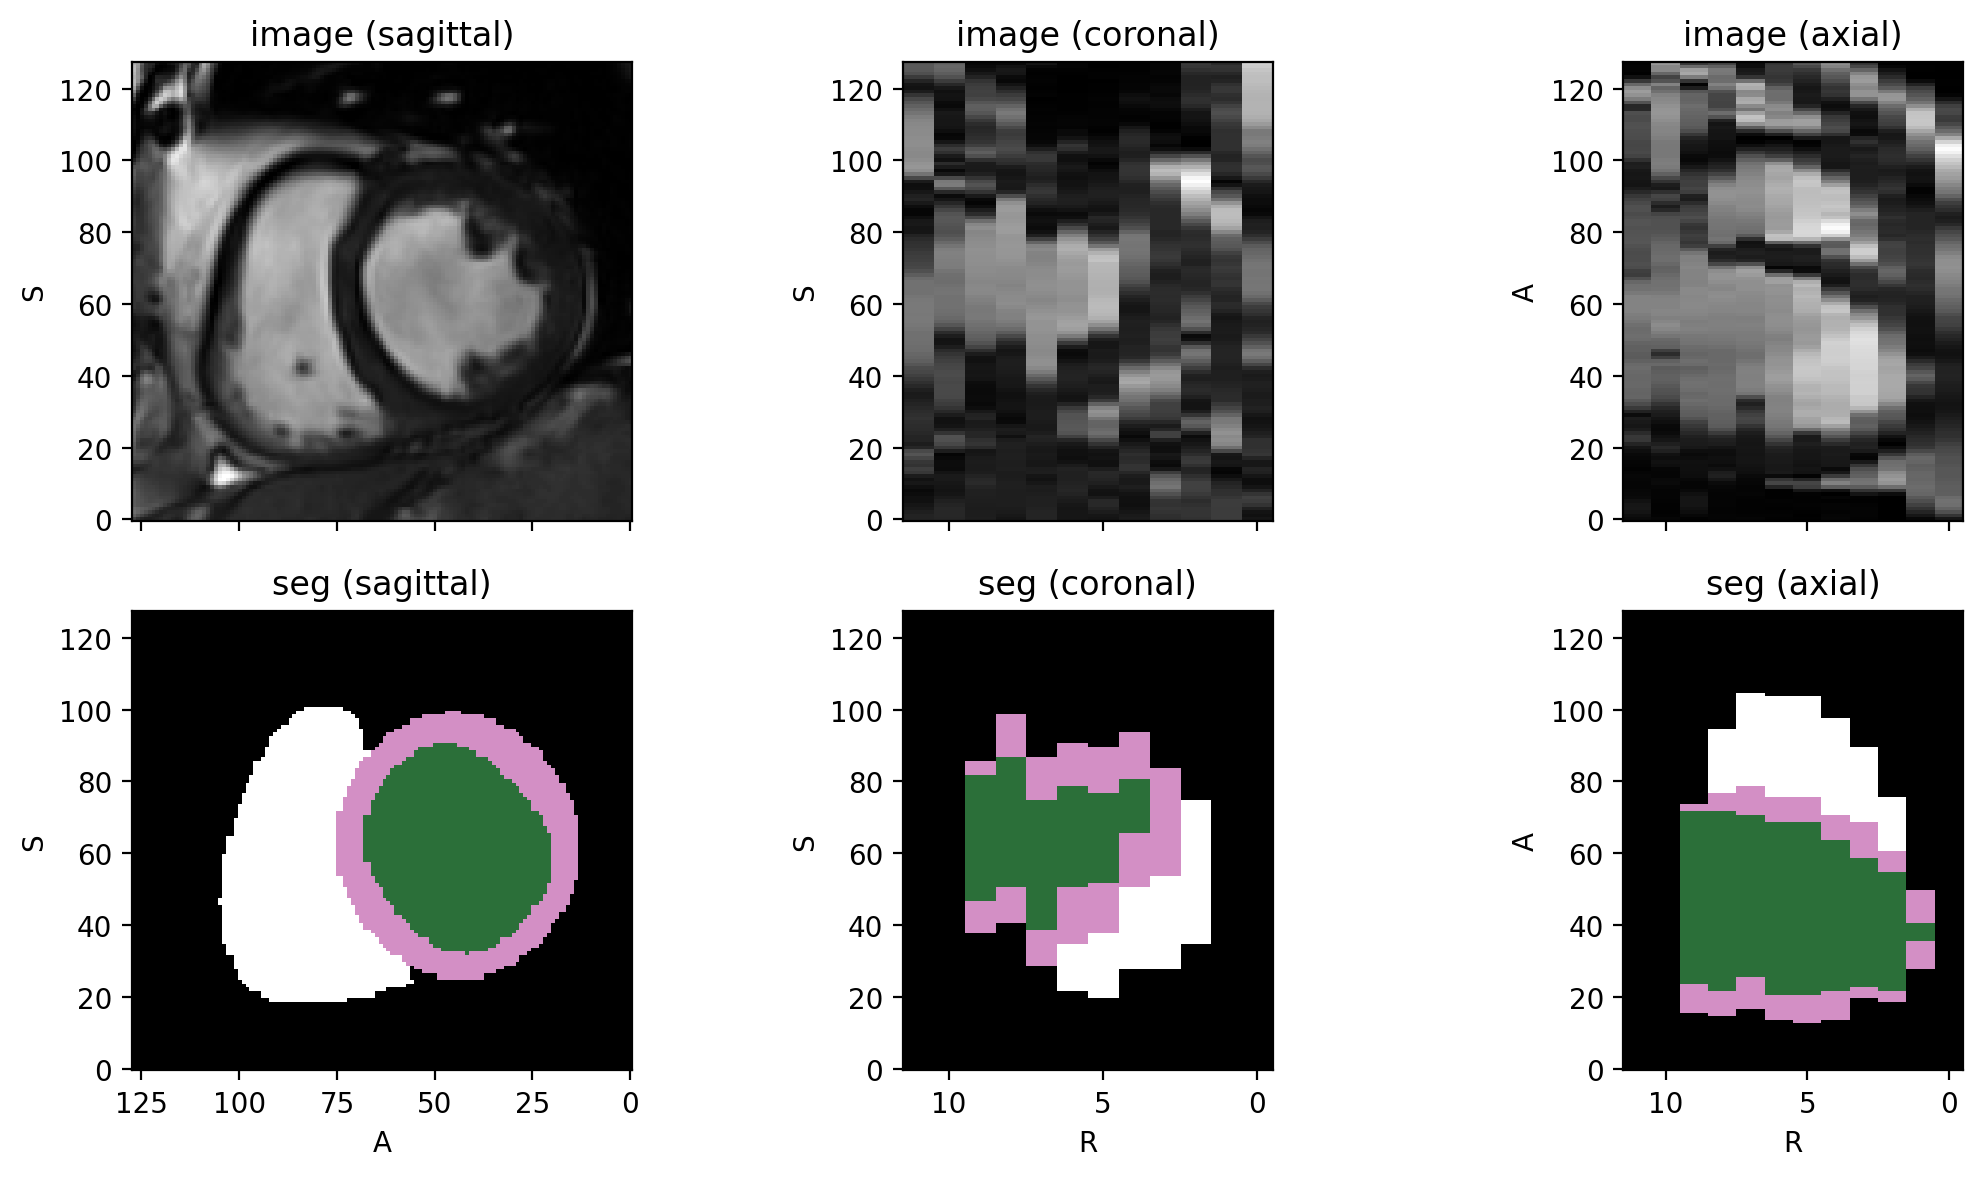

In [9]:
train_dataset_3D = load_3D("Training/Labeled/")
print("Total memory for train: ", get_total_memory(train_dataset_3D))
valid_dataset_3D = load_3D("Validation/")
print("Total memory for valid: ", get_total_memory(valid_dataset_3D))
test_dataset_3D = load_3D("Testing/")
print("Total memory for test: ", get_total_memory(test_dataset_3D))


one_subject = train_dataset_3D[0]
visualize_subject(one_subject)

100%|██████████| 150/150 [00:16<00:00,  8.95it/s]


Training/Labeled/ Dataset size: 3286 subjects


100%|██████████| 33/33 [00:03<00:00,  8.91it/s]


Validation/ Dataset size: 786 subjects


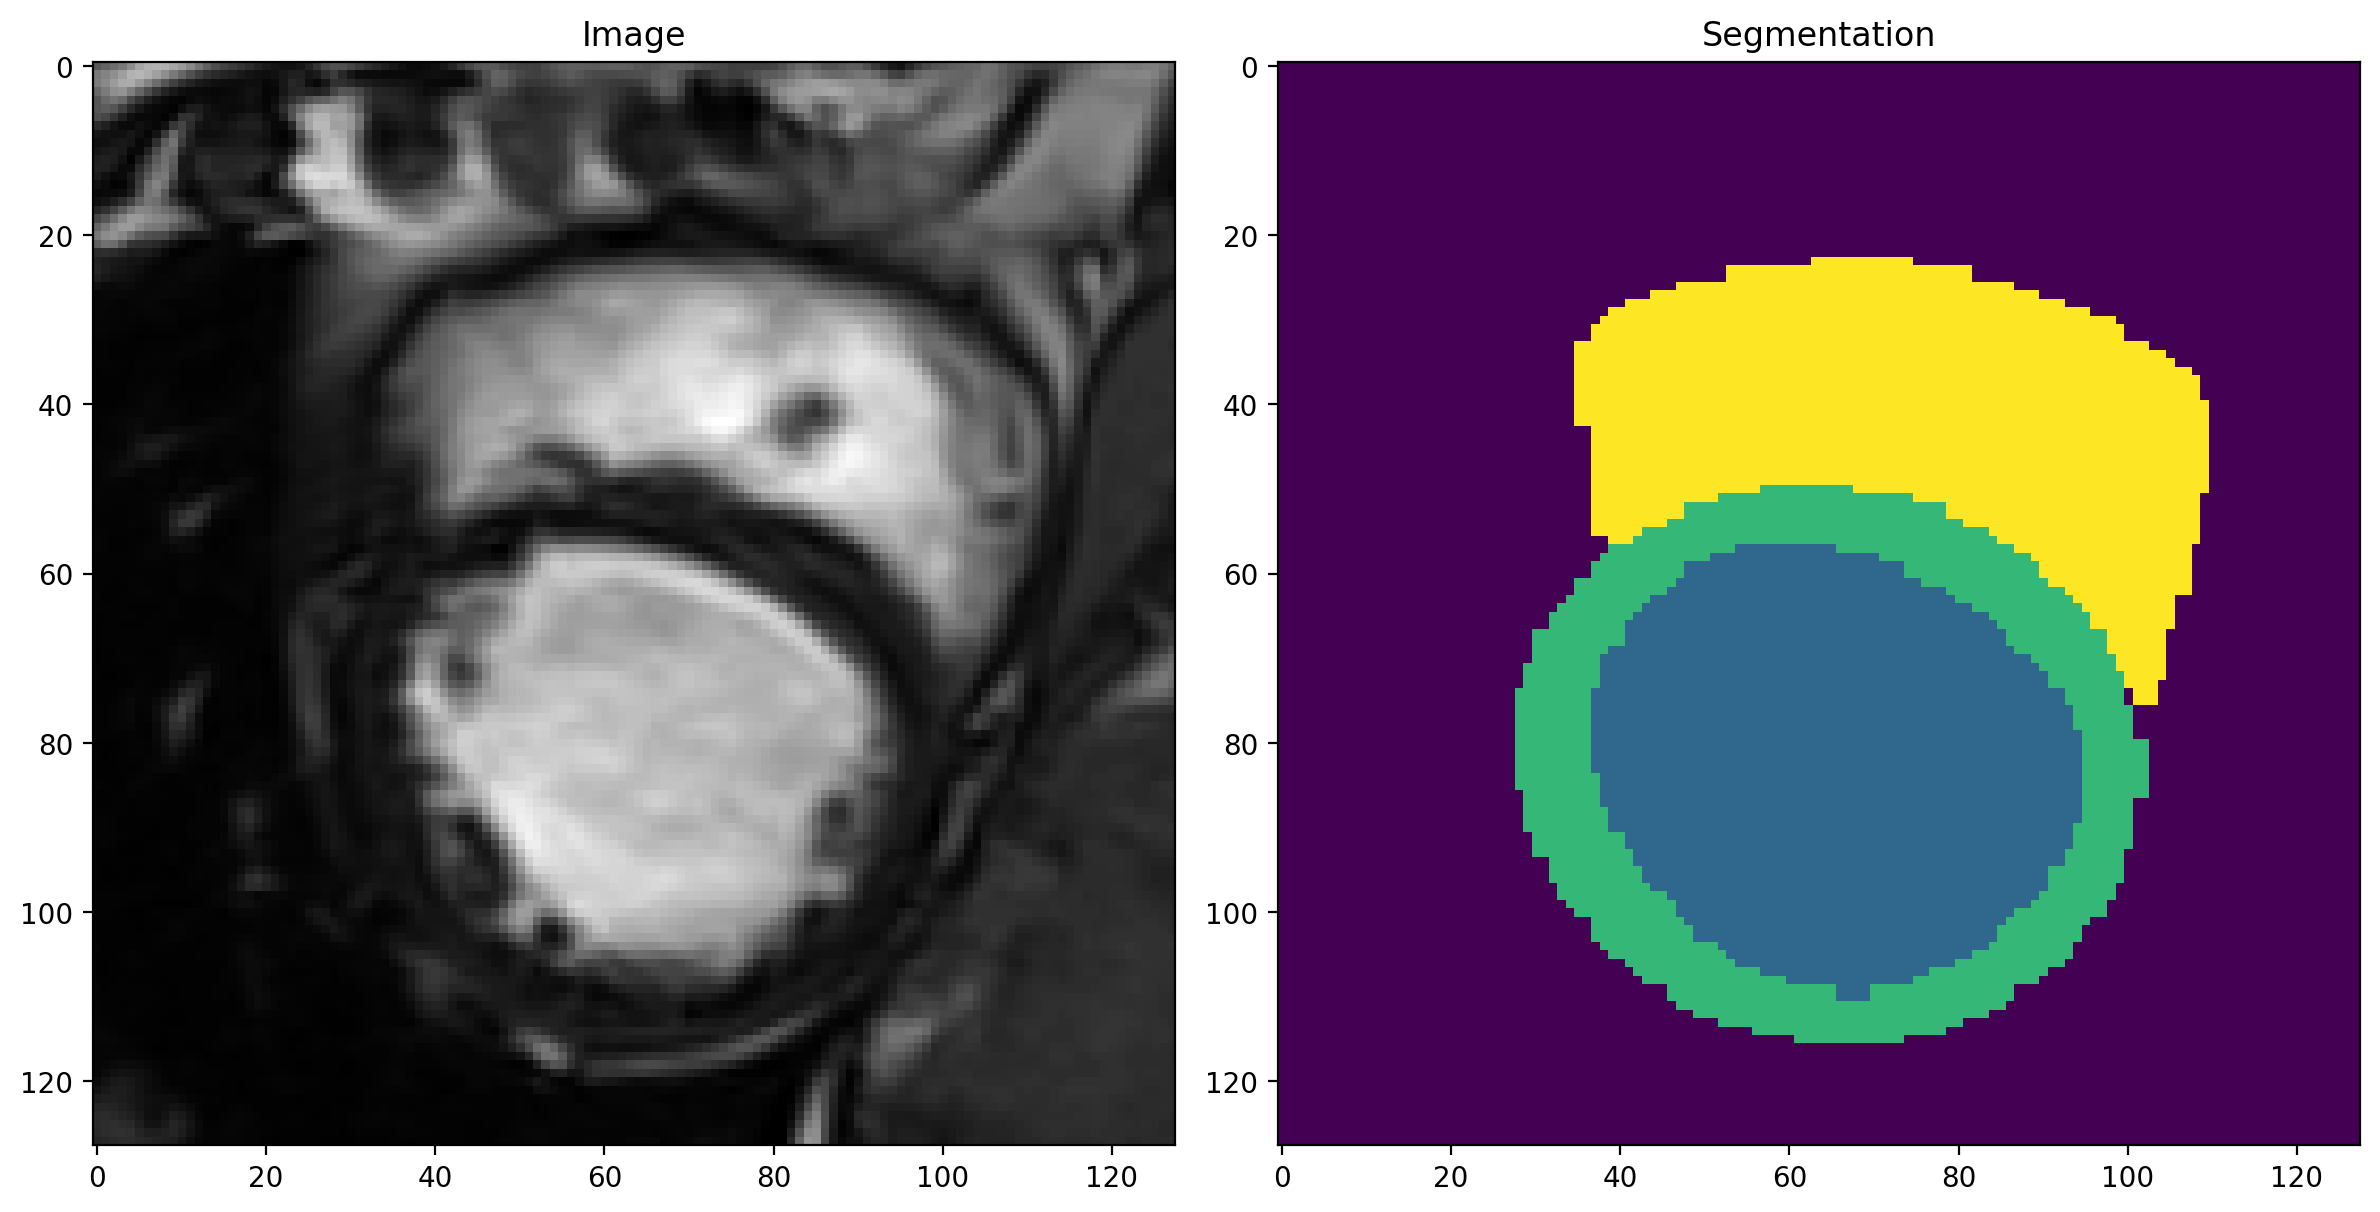

In [10]:
train_dataset = load_2D("Training/Labeled/")
valid_dataset = load_2D("Validation/")

image = train_dataset[10][0]
seg = train_dataset[10][1]
visualize_slice(image, seg)

# Unet

### Training

In [11]:
model = UNet(
    in_channels=1,
    out_classes=4,
    dimensions=2,
    num_encoding_blocks=5,
    out_channels_first_layer=16,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
)

optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.BCEWithLogitsLoss()

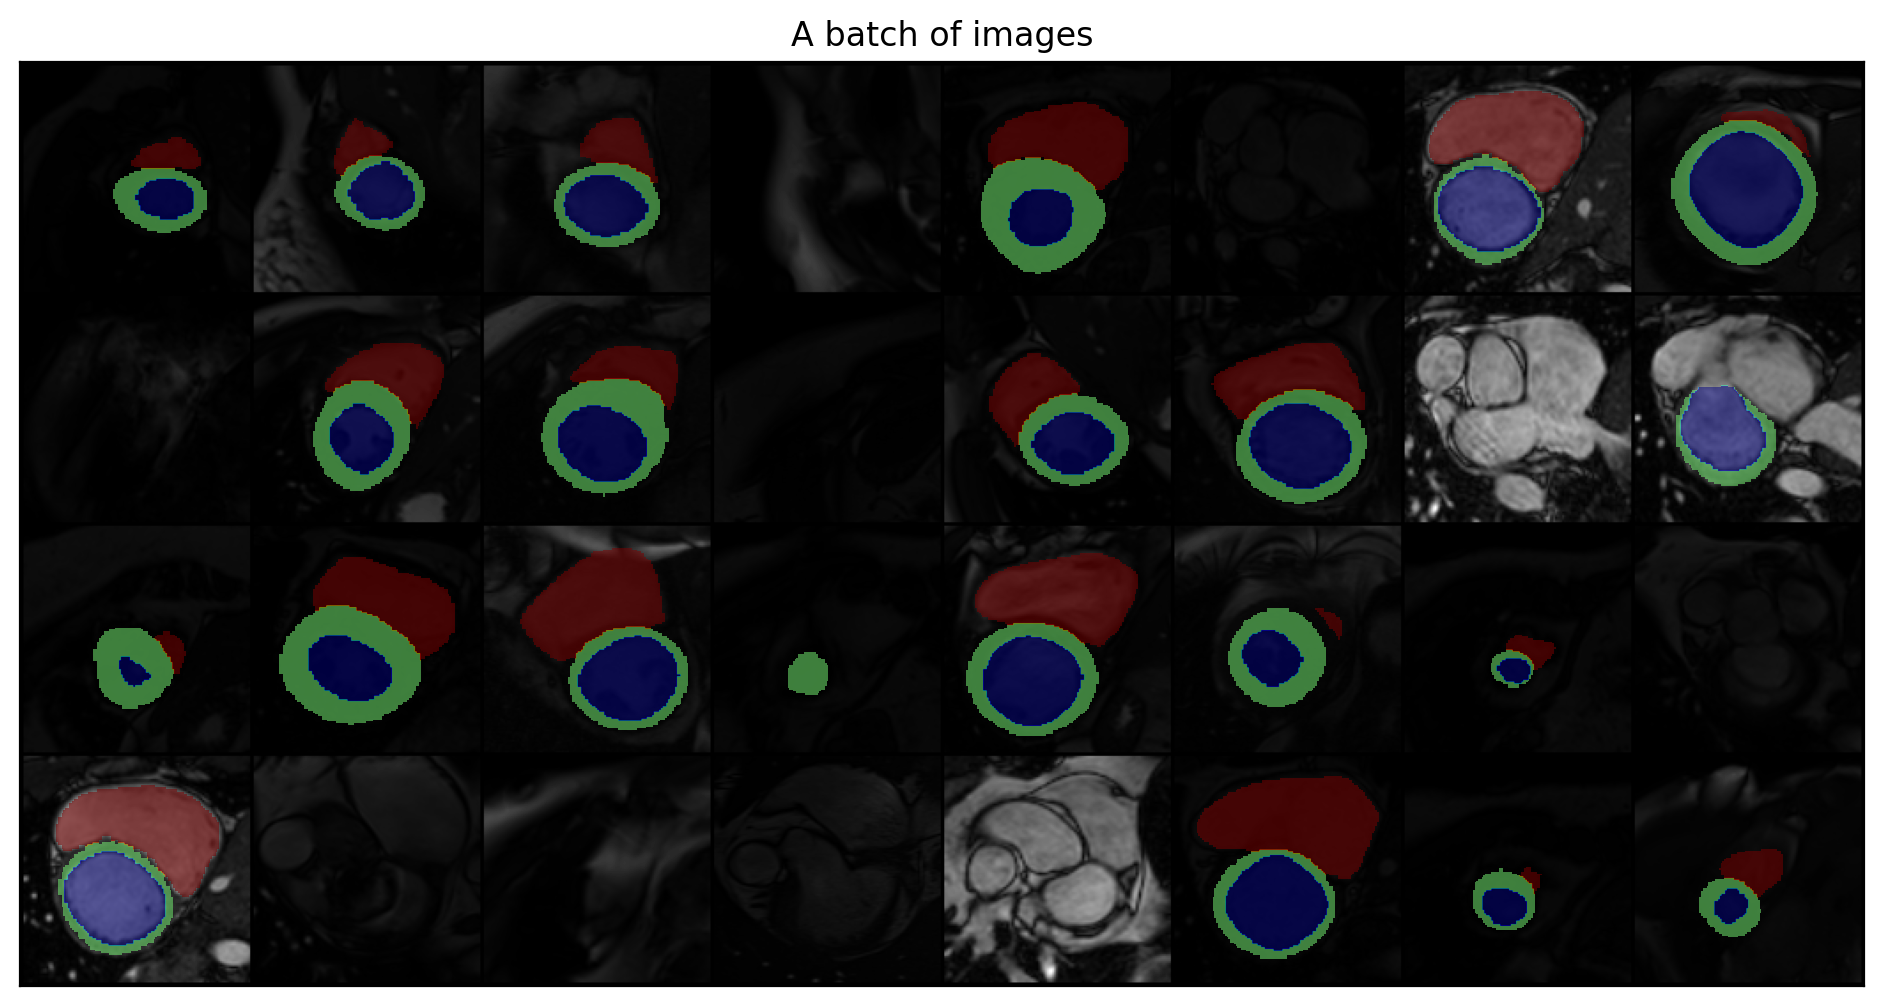

  3%|▎         | 1/30 [00:11<05:23, 11.15s/it]

Epoch [1/30]], Loss: 0.5326, Validation Loss: 0.4014


 37%|███▋      | 11/30 [01:37<02:43,  8.62s/it]

Epoch [11/30]], Loss: 0.0359, Validation Loss: 0.0809


 70%|███████   | 21/30 [03:03<01:17,  8.66s/it]

Epoch [21/30]], Loss: 0.0245, Validation Loss: 0.0646


100%|██████████| 30/30 [04:21<00:00,  8.70s/it]


In [12]:
num_epochs = 30
batch_size = 32
num_classes = 4
num_workers = 10
save = True
model_name = 'modelv4'

model = train_model(model, 
                    optimizer, 
                    criterion, 
                    device,  
                    train_dataset, 
                    valid_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    num_epochs=num_epochs,
                    verbose=3,
                    save=save,
                    model_name= model_name
                    )

In [17]:
if save:
    checkpoint = torch.load(f'models/{model_name}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    meta = checkpoint['metadata']
    num_epochs = meta['num_epochs']
    total_steps = meta['total_steps']
    train_losses = meta['train_losses']
    valid_losses = meta['valid_losses']

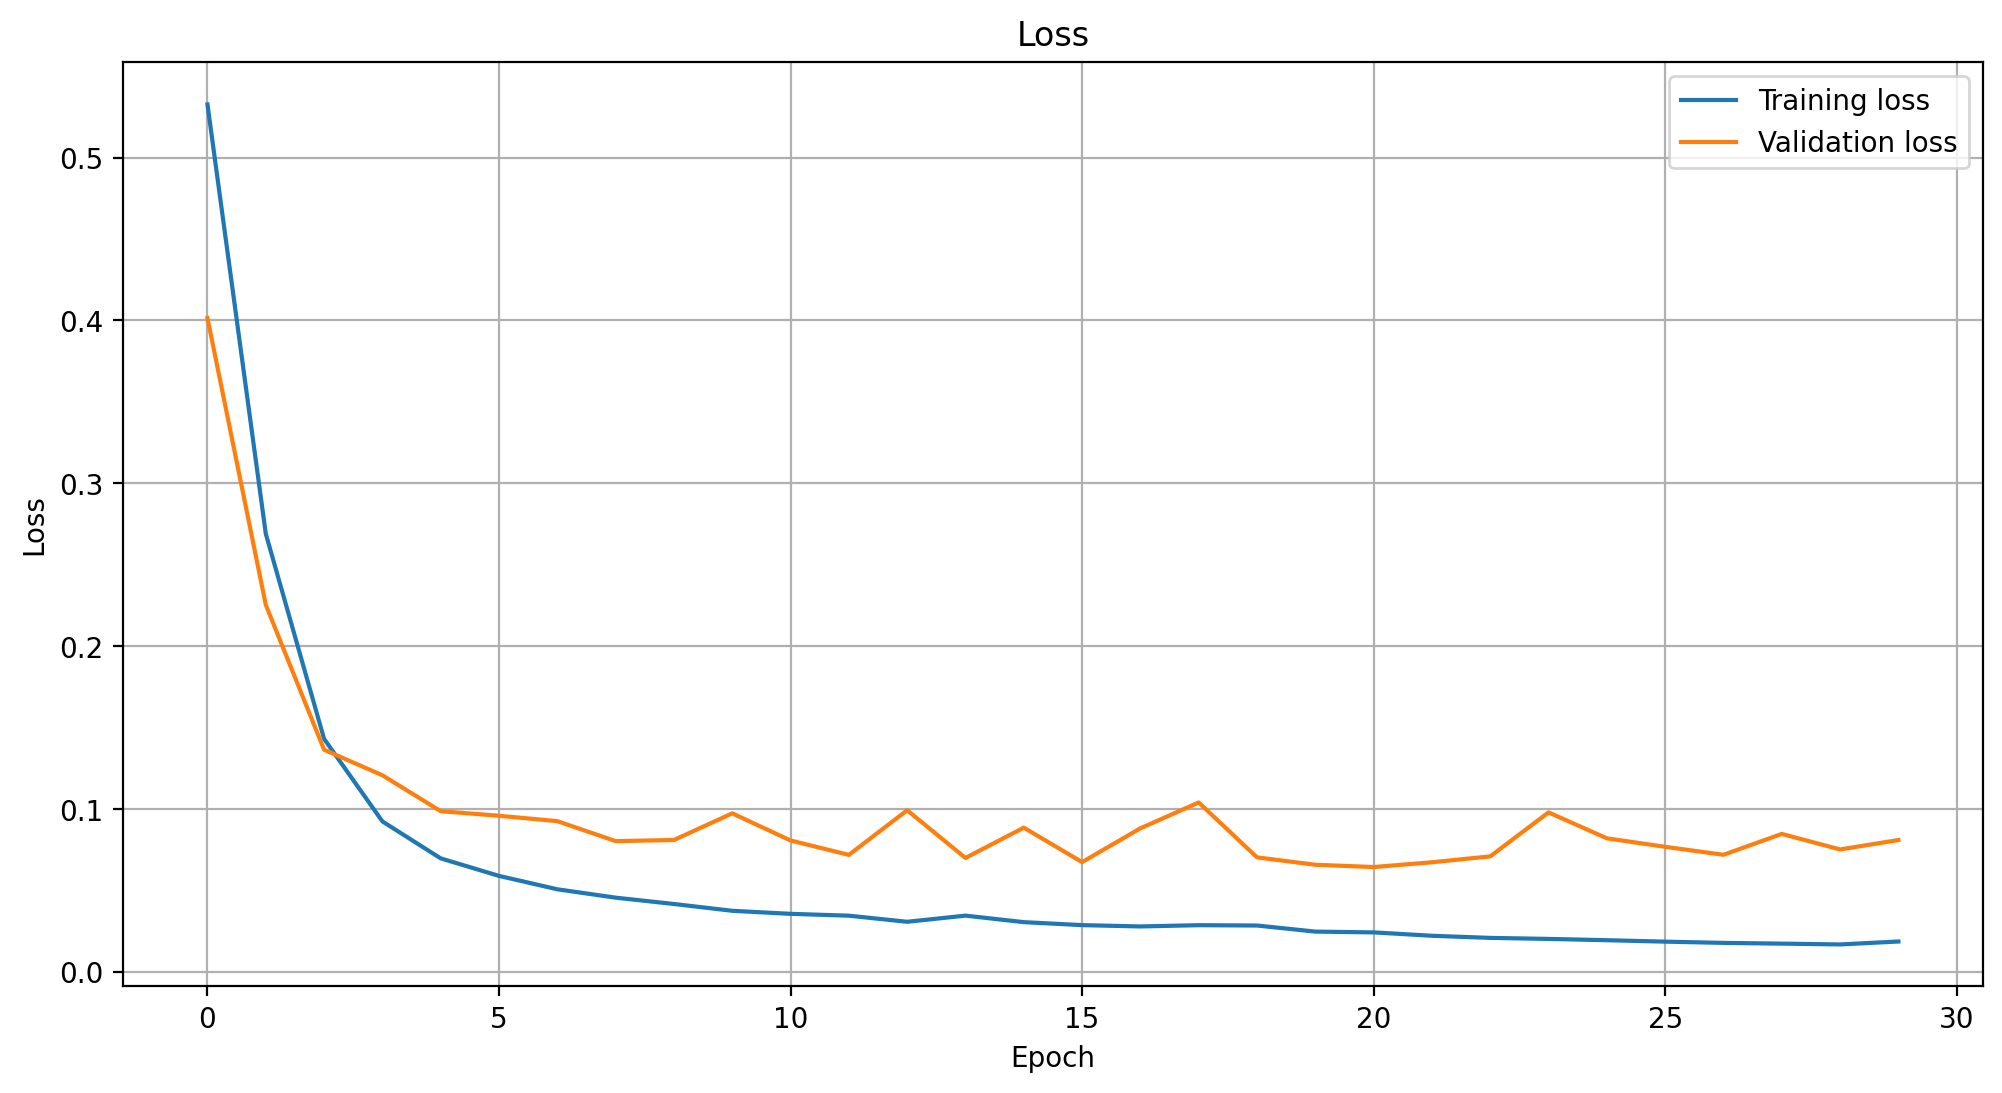

In [18]:
plt.plot(range(num_epochs) , train_losses, label="Training loss")
plt.plot(range(num_epochs) , valid_losses, label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Visualize results

In [35]:
images, labels = valid_dataset[:][0], valid_dataset[:][1]
predictions = predict(model, images, device)

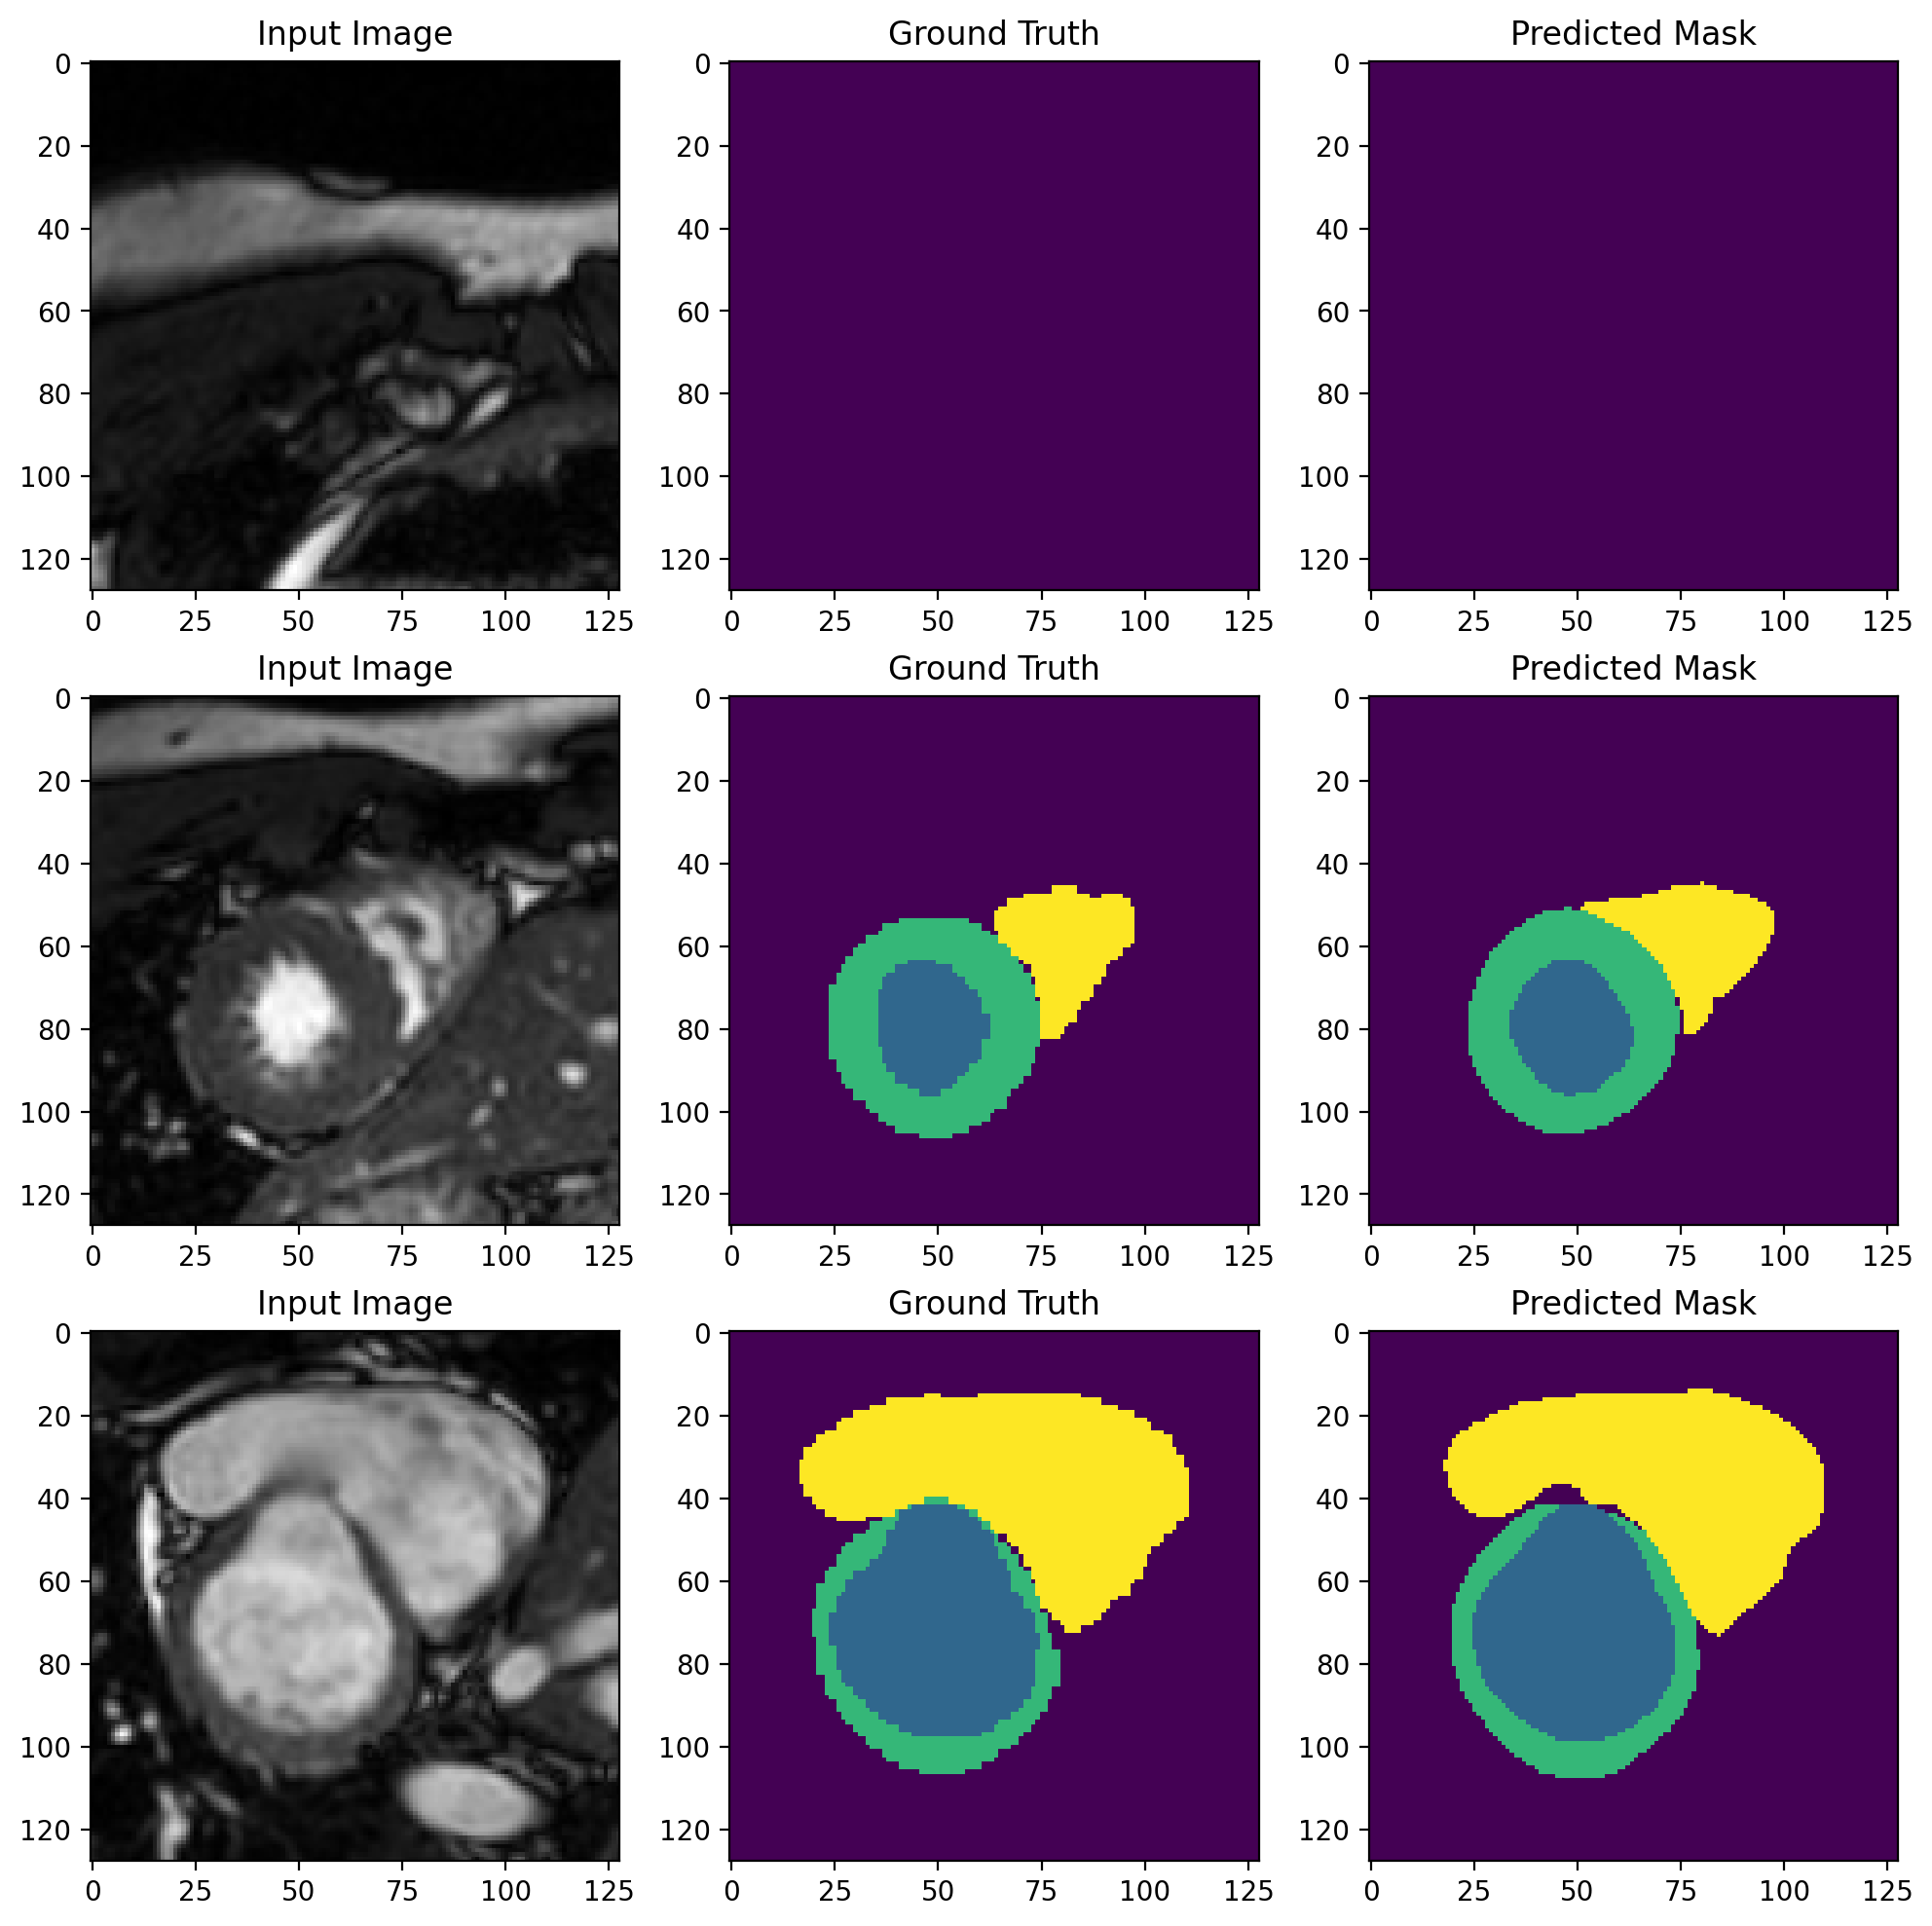

In [40]:
n_examples = 3
step = 9
visualize_predictions(images, labels, predictions, n_examples, step)

Vendor: D


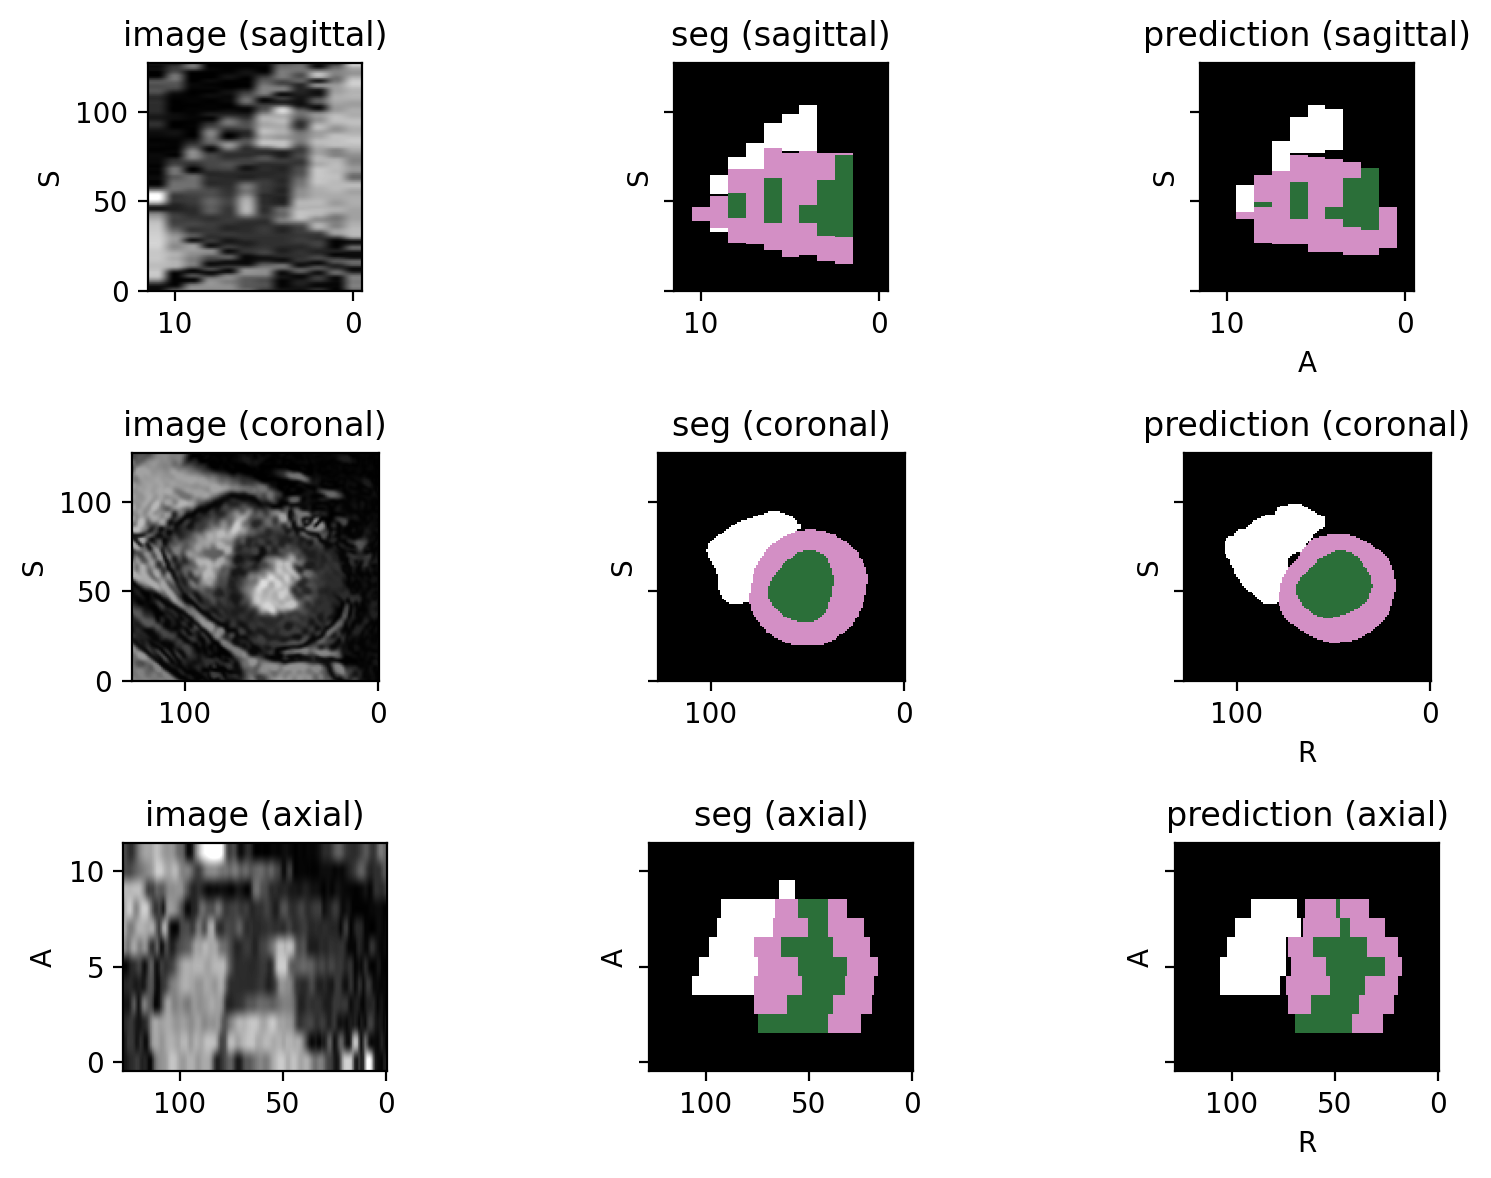

In [58]:
# Get data for one subject
one_subject = test_dataset_3D[10]
vendor = metadata.loc[one_subject.id].Vendor
print("Vendor:", vendor)
visualize_predictions_3D(model, one_subject, device)

### Dice Coefficient

In [49]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum().item()
    smooth = 0.0001
    return (2. * intersection + smooth) / (y_true_f.sum().item() + y_pred_f.sum().item() + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

num_class = 4

In [55]:
names = ["Train", "Valid", "Test"]
datasets = [train_dataset_3D, valid_dataset_3D, test_dataset_3D]
results= {}
for dataset_3D, name in zip(datasets, names):
    print(name)
    n = {"A":0, "B":0,"C":0,"D":0}
    dc = {"A":0., "B":0.,"C":0.,"D":0.}
    for i in range(len(dataset_3D)):
        # Get data for one subject
        subject = dataset_3D[i]
        labels = subject.seg.data 
        id = subject.id
        vendor = metadata.loc[id].Vendor
        
        # Make predictions
        c, x, y, z = labels.shape
        labels_stacked = labels.permute((0,3,1,2)).reshape(c*z ,x, y).long()
        labels_onehot = F.one_hot(labels_stacked, num_classes=4)

        predictions = predict_3D(model, subject, device)
        predictions_onehot = F.one_hot(predictions, num_classes=4)

        d = dice_coef_multilabel(labels_onehot, predictions_onehot, 4)

        n[vendor] += 1
        dc[vendor] += d

    for v in dc.keys():
        if n[v]!=0:
            dc[v] /= n[v]

    results[name] = {"dc": dc, "n": n}

Train
Valid
Test


In [56]:
for k1, v1 in results.items():
    print(k1)

    print("\tn:")
    for k3, v3 in v1["n"].items():
        print("\t\t", k3, ": ", v3)
        
    print("\tdc:")
    for k3, v3 in v1["dc"].items():
        print("\t\t", k3, ": {:.2%}".format(v3))


Train
	n:
		 A :  75
		 B :  75
		 C :  0
		 D :  0
	dc:
		 A : 94.52%
		 B : 94.90%
		 C : 0.00%
		 D : 0.00%
Valid
	n:
		 A :  4
		 B :  10
		 C :  9
		 D :  10
	dc:
		 A : 86.12%
		 B : 85.90%
		 C : 87.95%
		 D : 84.91%
Test
	n:
		 A :  16
		 B :  40
		 C :  38
		 D :  40
	dc:
		 A : 88.07%
		 B : 84.55%
		 C : 86.20%
		 D : 86.30%
